In [1]:
%%capture
# Install the latest Tensorflow version.
!pip install tensorflow_text
!pip install bokeh
!pip install simpleneighbors[annoy]
!pip install tqdm
!pip install unidecode

In [2]:
import os,re,collections
import numpy as np

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU,LSTM, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
import tensorflow.compat.v2 as tf
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ***Etape 1 : Chargement de données*** 
 Nous allons extraire les données qui se trouvent dans le zip dans le drive ainsi pouvoirs les exploité facilement puis nous allons organiser les fichier de sort a ce que chaque phrase aille sa traduction dans le fichier correspondant,les phrase qui seront extraitent du fichier vont étre prétraiter 

In [ ]:
import zipfile

#nous allons extraire nos données qui se trouvent dans un fichier zip dans notre drive 
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/rebuilt.Cross-Language-Dataset-master.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [6]:
#nous allons experimenter une partie de nos donnée dans cette partie on commence par le corpus APR 
English_Dataset = tf.data.Dataset.list_files("/tmp/Cross-Language-Dataset-master/dataset/chunks/APR/en/*.txt")
Frensh_Dataset = tf.data.Dataset.list_files("/tmp/Cross-Language-Dataset-master/dataset/chunks/APR/fr/*.txt")


In [7]:
#nous allons organiser nos fichier text de sort a ce que les fichier en francais aille leur traduction anglaise
English_DatasetFiles=list(English_Dataset.as_numpy_iterator())
English_DatasetFiles.sort()
Frensh_DatasetFiles=list(Frensh_Dataset .as_numpy_iterator())
Frensh_DatasetFiles.sort()

In [8]:
#cette fonction permet d'extraire extrait les donnees des fichier
def load_data(Files):
  sentences=[]
  for file_content in Files: 
    with open(file_content, "r") as f:
      data = f.read()
      sentences.append(data)
  return sentences

english_sentences=load_data(English_DatasetFiles)
french_sentences=load_data(Frensh_DatasetFiles)


In [9]:
for i in range(5):
  print('Sample :',i)
  print(english_sentences[i])
  print(french_sentences[i])
  print('-'*50)

Sample : 0
the association gregory lemarchal

l' association gregory lemarchal

--------------------------------------------------
Sample : 1
after the dresden file

après les dossier dresden

--------------------------------------------------
Sample : 2
the tradition of lanfeust troy
invention of reverse auctions

la tradition lanfeust de troy
invention des ventes aux enchères

--------------------------------------------------
Sample : 3
the manner of dos passos

la manière de dos passos

--------------------------------------------------
Sample : 4
trace of fat in this book

trace de gras dans le livre

--------------------------------------------------


# ***Etape 2 : Stopwords***
première manipulation souvent effectuée dans le traitement du texte est la suppression de ce qu'on appelle en anglais les stopwords. Ce sont les mots très courants dans la langue étudiée ("et", "à", "le"... en français) qui n'apportent pas de valeur informative pour la compréhension du "sens" d'un document et corpus. Il sont très fréquents et ralentissent notre travail : nous souhaitons donc les supprimer.

Il existe dans la librairie NLTK une liste par défaut des stopwords dans plusieurs Langues

In [10]:

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#pour supprimer les stopword de chaque langue
def remove_stopwords(text,langue):
    STOPWORDS = set(stopwords.words(langue))
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
#supprimer les stopword dans une liste de phrase
def remove(sentences,langue):
    values=[]
    for text in sentences:
       values.append(remove_stopwords(text,langue))
    return values


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:

english_sentences=remove(english_sentences,'english')
french_sentences=remove(french_sentences,'french')

In [13]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('English Vocab:',len(english_words_counter))
print('French Vocab:',len(french_words_counter))

English Vocab: 3981
French Vocab: 4271


# ***Etape 3 :le Stemming*** 
racinisation(ou stemming en anglais). Cela consiste à ne conserver que la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine. C'est un procédé plus simple que la lemmatisation et plus rapide à effectuer puisqu'on tronque les mots essentiellement contrairement à la lemmatisation qui nécessite d'utiliser un dictionnaire.Dans notre cas, on va effectuer une racinisation parce qu'il n'existe pas de fonction de lemmatisation de corpus français dans NLTK

In [14]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

def stem_words_langue(text,langue):
    stemmer2=SnowballStemmer(langue)
    return " ".join([stemmer2.stem(word) for word in text.split()])

def stemming_langue(sentences,langue):
  values=[]
  for text in sentences:
    values.append(stem_words_langue(text,langue))
  return values
 

In [16]:

english_sentences=stemming_langue(english_sentences,'english')
french_sentences=stemming_langue(french_sentences,'french')

## ***Etape 4 : la tokenisation***
La tokenisation est la division du texte brut en petits morceaux de mots ou de phrases, appelés jetons.Chaque phrase prend son sens par les mots qu'elle contient. Ainsi, en analysant les mots présents dans le texte, nous pouvons facilement interpréter le sens du texte. Une fois que nous avons une liste de mots, nous pouvons également utiliser des outils et des méthodes statistiques pour mieux comprendre le texte. Par exemple, nous pouvons utiliser le nombre de mots et la fréquence des mots pour découvrir l'importance d'un mot dans cette phrase ou ce document.

In [17]:
def tokenize(x):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(x)
  return tokenizer.texts_to_sequences(x), tokenizer

In [18]:
def pad(x, length=None):
  return pad_sequences(x, maxlen=length, padding='post')

In [19]:
def preprocess(x, y):
    """
      Prétraiter x et y
    : param x: Feature Liste des phrases
    : param y: Label Liste des phrases
    : return: Tuple de (pré-traité x, pré-traité y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # La fonction sparse_categorical_crossentropy de Keras nécessite que les étiquettes soient en 3 dimensions
    # Extension des dimensions
    
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [20]:
preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)

In [21]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 31
Max French sentence length: 34
English vocabulary size: 3608
French vocabulary size: 3691


In [22]:
def logits_to_text(logits, tokenizer):
  index_to_words = {id: word for word, id in tokenizer.word_index.items()}
  index_to_words[0] = '<PAD>'

   # Nous prédisons la sortie pour un mot donné, puis sélectionnons la meilleure réponse
   # En sélectionnant cette étiquette, nous énumérons le mot à partir de l'identifiant
    
  return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [23]:

tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# ***Etape 5 les Word embedding*** 
Nous allons utilisée un prétrained model Glove word embedding 

In [24]:
glove_dir = '/content/drive/MyDrive/glove/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
embedding_dim = 100
max_words = english_vocab_size+1
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in english_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

# ***Etape 6 : Model***
Nous allons maintenant procedé a la creation de notre model neuronal ,l'entrainer et l'evaluer puis afficher les resulats  à l'aide d'un graphe

In [26]:
def DNN_Model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):

  learning_rate = 0.005
  model = Sequential()             
  model.add(Embedding(english_vocab_size, 100, weights=[embedding_matrix],input_length=input_shape[1], input_shape=input_shape[1:]))
  model.add(Dense(32, activation=tf.nn.relu ))
  model.add(Dense(32, activation=tf.nn.relu))
  model.add(Dense(32, activation=tf.nn.relu))
  model.add(Dense(french_vocab_size))
  model.summary()
  model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
  return model

DNN_Model = DNN_Model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

history=DNN_Model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=200, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 100)           360900    
_________________________________________________________________
dense (Dense)                (None, 34, 32)            3232      
_________________________________________________________________
dense_1 (Dense)              (None, 34, 32)            1056      
_________________________________________________________________
dense_2 (Dense)              (None, 34, 32)            1056      
_________________________________________________________________
dense_3 (Dense)              (None, 34, 3692)          121836    
Total params: 488,080
Trainable params: 488,080
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
2/2 [==============================] - 21s 3s/step - loss: 8.5747 - accuracy: 0.6960 - val_loss: 5.6969 

In [27]:
scores =  DNN_Model.evaluate(tmp_x, preproc_french_sentences, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 84.29%


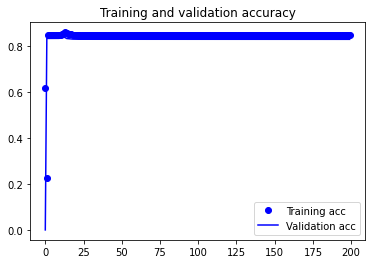

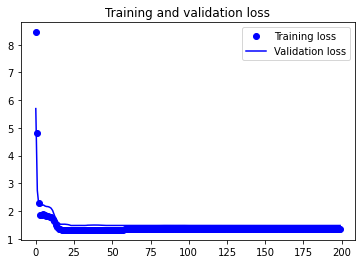

In [28]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def final_predictions(text):
  y_id_to_word = {value: key for key, value in french_tokenizer.word_index.items()}
  y_id_to_word[0] = '<PAD>'

  sentence = [english_tokenizer.word_index[word] for word in text.split()]
  sentence = pad_sequences([sentence], maxlen=preproc_french_sentences.shape[-2], padding='post')
  
  print(sentence.shape)
  print(logits_to_text(simple_rnn_model.predict(sentence[:1])[0], french_tokenizer))

In [ ]:
DNN_Model.save('model')

NameError: ignored

In [ ]:
! mkdir "pickles"

In [ ]:
with open('pickles/french_tokenizer.pickle', 'wb') as handle:
    pickle.dump(french_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('pickles/english_tokenizer.pickle', 'wb') as handle:
    pickle.dump(english_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('pickles/preproc_french_sentences.pickle', 'wb') as handle:
    pickle.dump(preproc_french_sentences, handle, protocol=pickle.HIGHEST_PROTOCOL) 